In [5]:
from mesa.space import MultiGrid

from typing import Dict, List, Tuple

class CityGrid(MultiGrid):
    """A grid representing a city with buildings.

    Attributes
    ----------
    locations : Dict[str, List[Tuple[int, int]]]
        Map of locations of buildings.

    """
    locations: Dict[str, List[Tuple[int, int]]]
    __busy_positions: List[Tuple[int, int]]
       
    def __init__(self, width: int, height: int, torus: bool, \
    locations: Dict[str, List[Tuple[int, int]]]) -> None:
        """Create a new city grid.

        Parameters
        ----------
        width : int
        height : int
        torus : bool
        locations : Dict[str, List[Tuple[int, int]]]
            Map of locations.

        Raises
        ------
        ValueError
            if the locations are not consistent.
        
        See Also
        --------
        mesa.space.MultiGrid

        """
        super().__init__(width, height, torus)
        self.__busy_positions = []
        self.__check_consistent_locations(width, height, locations)
        self.locations = locations


    def __check_consistent_locations(
        self,
        width: int,
        height: int,
        locations: Dict[str, List[Tuple[int, int]]]
    ) -> None:
        """Check that the locations are consistent with grid size and among
        themselves."""
        for l in locations.values():
            for x, y in l:
                if x<0 or x>width or y<0 or y>height:
                    raise ValueError(f"position ({x, y}) outside of grid \
                    dimensions")
                if (x, y) in self.__busy_positions:
                    raise ValueError(f"position ({x, y}) is already busy")
                self.__busy_positions.append((x, y))


    def is_busy(self, x: int, y: int) -> bool:
        """Check if some locations has a building of any type.

        Parameters
        ----------
        x : int
        y : int

        Returns
        -------
        bool
        
        """
        return (x, y) in self.__busy_positions
    

    def add_location(self, type: str, x: int, y:int) -> None:
        """Set a location as containing a building of some type.

        Parameters
        ----------
        type : str
        x : int
        y : int

        Raises
        ------
        ValueError
            If the input location is already busy.
            
        """
        if (x, y) in self.__busy_positions:
            raise ValueError(f"position ({x, y}) is already busy")
        try:
            self.locations[type].append((x, y))
        except KeyError:
            self.locations[type] = [(x, y)]
        self.__busy_positions.append((x, y))


In [49]:
import mesa
from city import CityGrid

locs = {
    'school': [(0, 1), (3, 3)],
    'hospital': [(1, 1)],
    'leisure': [(2, 4), (5, 5)],
    'houses': [(2, 3), (5, 3), (1, 2), (3, 4), (5, 6)],
    'work' : [(1, 0), (6, 6)]
}

class Apo_Agent(mesa.Agent):
    """An agent with BCN income."""
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 0
        self.home = None
        self.age = None
    
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.location, moore=True, include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
        self.location = new_position
    
    def go_to_work(self):
        self.model.grid.move_agent(self, self.random.choice(self.model.locs['work']))

    def go_to_leisure(self):
        self.model.grid.move_agent(self, self.random.choice(self.model.locs['leisure']))
        
    def go_home(self):
        self.model.grid.move_agent(self, self.model.locs['houses'][self.unique_id])
    
    def step(self):
        print("Position of "+ str(self.unique_id) +" is " + str(self.pos))

class Apo_Model(mesa.Model):
    def __init__(self, N, width, height, wealth_list):
        self.num_agents = N
        self.locs = locs
        self.grid = CityGrid(width, height, False, locs) 
        self.wealth_list = wealth_list
        self.time_of_day = "morning"
        
        # Scheduler
        self.schedule = mesa.time.RandomActivation(self)
        
        # Create agents
        for i in range(self.num_agents):
            ag = Apo_Agent(i, self)
            self.schedule.add(ag)
            ag.wealth = 0 #wealth_list[i]
            ag.home = self.locs['houses'][i]
            #ag.age = self.
            
        # Initialize data collector
        self.datacollector = mesa.DataCollector(
            model_reporters={"Agent Positions": lambda m: [a.pos for a in m.schedule.agents]}, agent_reporters= {"Wealth": lambda a: a.wealth})

    def step(self):
        time = self.schedule.time % 24
        if time == 0: 
            for agent in self.schedule.agents:
                self.grid.place_agent(agent, agent.home)
        # Schedule agents to go to work in the morning
        if 0 < time < 8:
            for agent in self.schedule.agents:
                agent.go_to_work()
        
        # Schedule agents to go to leisure locations in the afternoon
        if 8 <= time < 16:
            for agent in self.schedule.agents:
                agent.go_to_leisure()
        
        # Schedule agents to go home at night
        else:
            for agent in self.schedule.agents:
                agent.go_home()

        #when a month has passed, mensuality is given to the agents

        if self.schedule.time % 672 == 0:
            for agent in self.schedule.agents:
                agent.wealth += self.wealth_list[agent.unique_id]

        # Collect agent positions
        self.datacollector.collect(self)
        print(time)
        self.schedule.step()
        

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
N = 5
X = 10
Y = 10

income = pd.read_csv('C:/Users/albaa/Escriptori/MasterModelitzacio/JAE/pythonmesa/mesa/2020_atles_renda_bruta_persona.csv')
monthly_wealth = np.array(income['Import_Renda_Bruta_€']) / 12

model = Apo_Model(N, X, Y, monthly_wealth)
for i in range(700):
    model.step()

0
Position of 0 is (2, 3)
Position of 3 is (3, 4)
Position of 2 is (1, 2)
Position of 4 is (5, 6)
Position of 1 is (5, 3)
1
Position of 0 is (2, 3)
Position of 4 is (5, 6)
Position of 3 is (3, 4)
Position of 1 is (5, 3)
Position of 2 is (1, 2)
2
Position of 1 is (5, 3)
Position of 4 is (5, 6)
Position of 2 is (1, 2)
Position of 0 is (2, 3)
Position of 3 is (3, 4)
3
Position of 4 is (5, 6)
Position of 0 is (2, 3)
Position of 2 is (1, 2)
Position of 3 is (3, 4)
Position of 1 is (5, 3)
4
Position of 1 is (5, 3)
Position of 2 is (1, 2)
Position of 0 is (2, 3)
Position of 4 is (5, 6)
Position of 3 is (3, 4)
5
Position of 2 is (1, 2)
Position of 4 is (5, 6)
Position of 0 is (2, 3)
Position of 1 is (5, 3)
Position of 3 is (3, 4)
6
Position of 3 is (3, 4)
Position of 2 is (1, 2)
Position of 4 is (5, 6)
Position of 0 is (2, 3)
Position of 1 is (5, 3)
7
Position of 0 is (2, 3)
Position of 3 is (3, 4)
Position of 4 is (5, 6)
Position of 1 is (5, 3)
Position of 2 is (1, 2)
8
Position of 0 is (5, 5

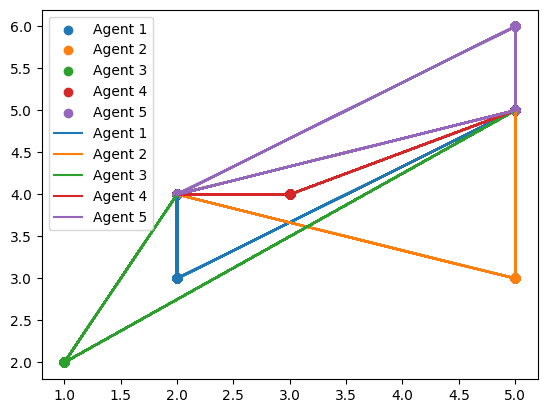

In [59]:

positions = model.datacollector.get_model_vars_dataframe()

def extract_position(row, agent_index):
    return row['Agent Positions'][agent_index]

for i in range(N):
    positions[f'Agent {i+1}'] = positions.apply(lambda row: extract_position(row, i), axis=1)

fig, ax = plt.subplots()
for i in range(N):
    agent_col = f'Agent {i+1}'
    ax.scatter(positions[agent_col].apply(lambda x: x[0]), positions[agent_col].apply(lambda x: x[1]), label=agent_col)
    positions[f'Agent {i+1} X'] = [pos[i][0] for pos in positions['Agent Positions']]
    positions[f'Agent {i+1} Y'] = [pos[i][1] for pos in positions['Agent Positions']]

# each agent's trajectory
for i in range(N):
    ax.plot(positions[f'Agent {i+1} X'], positions[f'Agent {i+1} Y'], label=f'Agent {i+1}')

ax.legend()
plt.show()

Ara ja tenim agents que a cada moment del dia determinat van al lloc on els toca. Anem a incorporar la mensualitat de cada mes i plotar un histograma del total quan acabem tot el temps que hem posat. Ja veiem que quan superen un mes d'hores, es duplica el seu wealth. 

PREGUNTES: L'STEP de l'agent es util d'alguna manera, ho he posat tot al step del model perq necessito la variable time per definirho tot. 

La idea és que el model funcioni per qualsevol ciutat, li puguis tu adjuntar les dades de OPENDATA i runnejar quines polítiques redueixen la pobresa de la ciutat. 


In [61]:
wealth = model.datacollector.get_agent_vars_dataframe()
wealth

all_wealth = []

for agent in model.schedule.agents:
    all_wealth.append(wealth)

plt.hist(all_wealth, bins=range(int(max(all_wealth)) + 1))
plt.show()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().